# Create a Custom Callback in Keras

# Task 1: Importing Libraries

In [1]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


# Task 2: Importing and Preprocessing Data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = np.reshape(X_train, (X_train.shape[0], 784)) / 255.
X_test = np.reshape(X_test, (X_test.shape[0], 784)) / 255.

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


# Task 3: Creating the Model

In [3]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(16, activation='relu', input_shape=(784,)),
                                    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


# Tasks 4 & 5: Creating the Callback

In [4]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, fraction):
        super().__init__()

        self.fraction = fraction
        self.train_ac = []
        self.val_ac = []

        with open('log.txt', 'w') as f:
            f.write('Start of logging......\n')

        self.fig = plt.figure(figsize=(4,3))
        self.ax = plt.subplot(1, 1, 1)
        plt.ion()
    
    def on_train_begin(self, logs=None):
        self.fig.show()
        self.fig.canvas.draw()
    
    def on_train_end(self, logs=None):
        with open('log.txt', 'a') as f:
            f.write('End of logging........\n')
    
    def on_epoch_begin(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        lr *= self.fraction
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        with open('log.txt', 'a') as f:
            f.write('At epoch {:2d}, learning rate changed to {:.4f}\n'.format(epoch, lr))

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        
        self.val_ac.append(val_acc)
        self.train_ac.append(train_acc)

        with open('log.txt','a') as f:
            f.write('At epoch {:2d}, training accuracy: {:.3f}, validation accuracy: {:.3f}'.format(
                epoch, train_acc, val_acc
            ))

        self.ax.clear()
        self.ax.plot(range(1+epoch), self.train_ac,label='Train')
        self.ax.plot(range(1+epoch), self.val_ac, label='Validation')
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Accuracy')
        self.ax.legend()
        self.fig.canvas.draw()

# Task 6: Training the Model

<IPython.core.display.Javascript object>


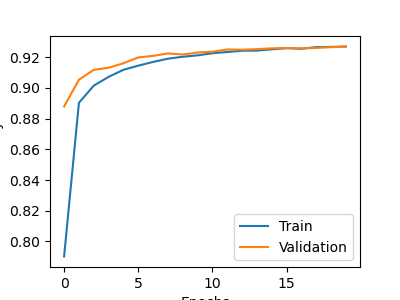

In [5]:
cc = CustomCallback(fraction=0.9)

In [6]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20, verbose=False,
    callbacks =[cc]
)